## E1 - Label Noise

I implemented 2LR Plugin-Approach (Bobs Paper) and analyse how label noise affects the tradeoff between Fairness and Performance

Fairness Metric: Mean Distance
Performance Metric: Balanced Error

In [1]:

from random import seed, shuffle
import sys
sys.path.insert(1, '/home/preuer/OneDrive/Studium/Master/Semester/Sem_4/Master Thesis/Experiments/tools') # so i can import tools
from  gen_synth_data import *
from plot_helper import *
from corrupt_labels import *
from calc_metrics import *
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
#Configuration to make plots nicer
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Data Generation and Regression Fitting

In [12]:
np.random.seed(0)  # Set seed for reproducibility
flip_prob = 0.5  # Probability of flipping each value
disc_factor = 0.5


X, Y, Y_sen = generate_synthetic_data(False, n_samples=2000, disc_factor=disc_factor)    #n_samples are per gaussian distributions, we have two hence total_n = 2*n_samples

Y_corrupted = add_bin_noise(Y, flip_prob)
Y_sen_corrupted = add_bin_noise(Y_sen, flip_prob)

#Devide Set into training and test set
split_index = int(0.7 * len(X))

# Split the points into training and testing sets (80/20)
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]
Y_sen_train, Y_sen_test = Y_sen[:split_index], Y_sen[split_index:]
Y_corr_train, Y_corr_test = Y_corrupted[:split_index], Y_corrupted[split_index:]
Y_sen_corr_train, Y_sen_corr_test = Y_sen_corrupted[:split_index], Y_sen_corrupted[split_index:]


p_reg, p_reg_cor, f_reg, f_reg_cor = LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression()
p_reg.fit(X_train, Y_train)
p_reg_cor.fit(X_train, Y_corr_train)
f_reg.fit(X_train, Y_sen_train)
f_reg_cor.fit(X_train, Y_sen_corr_train)

LogisticRegression()

### Visualize the data

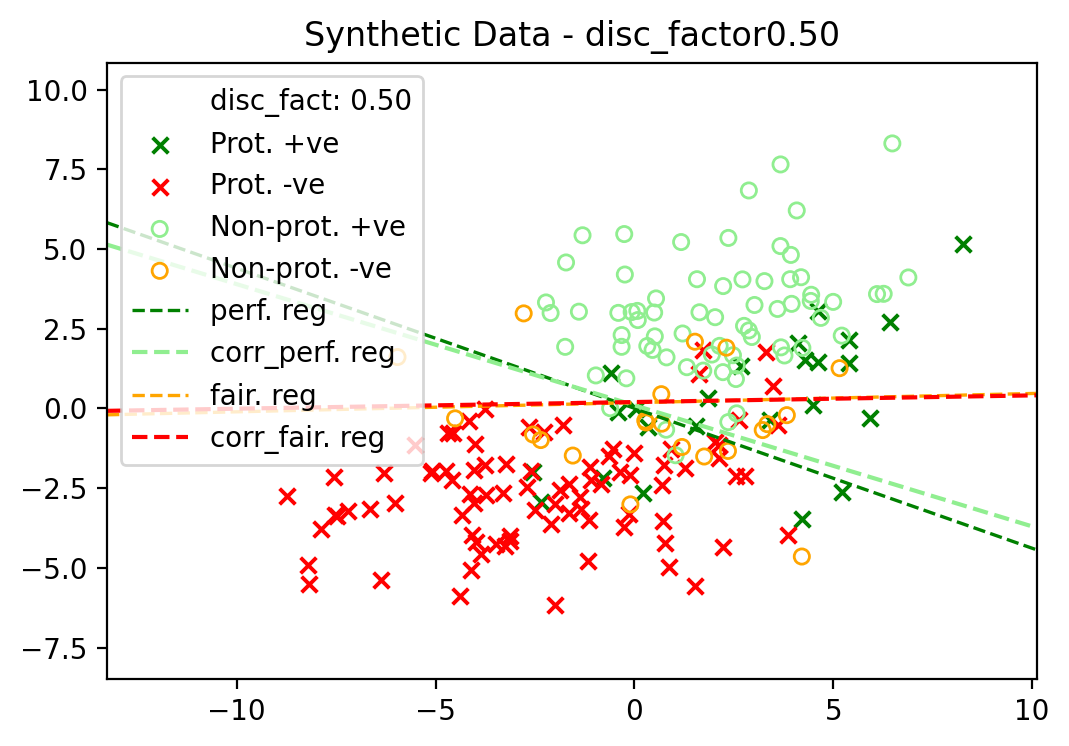

In [13]:

#We only draw a small number of points to avoid clutter in plot
num_to_draw = 200
x_draw = X[:num_to_draw]
y_draw = Y[:num_to_draw]
Y_sen_draw = Y_sen[:num_to_draw]

X_s_0 = x_draw[Y_sen_draw == 0.0]
X_s_1 = x_draw[Y_sen_draw == 1.0]
y_s_0 = y_draw[Y_sen_draw == 0.0]
y_s_1 = y_draw[Y_sen_draw == 1.0]

# Create a mesh grid of points
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict class probabilities Y=1|X for each point on the grid
Y_pred_p = p_reg.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
Y_pred_p_cor = p_reg_cor.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
Y_pred_f = f_reg.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
Y_pred_f_cor = f_reg_cor.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

#Plotting
fig, axs = plt.subplots(1, figsize=(6, 4))

    #for i, a in enumerate(np.linspace(0, 1, 6)):
    #    Y_pred_all = a*Y_pred_p_cor + (1-a)*Y_pred_f_cor
subplot_reg_corr(fig, axs, Y_pred_p, Y_pred_p_cor, Y_pred_f,Y_pred_f_cor, xx, yy, X_s_0, y_s_0, X_s_1, y_s_1, disc_factor=disc_factor, legend_outside=False)
    #plt.savefig(f"img/fairness_aware_regression_synthetic_data_rnd_label_noise_6/fairness_aware_regression_df_{df:.2f}_label_noise_{flip_prob}.png")

### Metrics Calculation and Plotting

In [18]:

# Initialize lists to store BER and MD for each lambda value
lmd_values = np.linspace(0, 2, 100)  # 100 values from 0 to 4
BER_list = []
MD_list = []
DI_list = []

# Constants c and c_bar (cost sensitivity of classes)
c, c_bar = 0.5, 0.5

# lmd = how important is fairness
for lmd in lmd_values:
    # Calculate 's' for each lambda
    s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)

    # Apply step function H_a(z) with a = 0
    Y_pred = np.where(s > 0, 1, 0)
    
    
    BER = calc_BER(Y_pred, Y_test)
    MD = calc_MD(Y_pred, Y_sen_test, True)
    DI = calc_DI(Y_pred, Y_sen_test, True)
    BER_list.append(BER)
    MD_list.append(MD)
    DI_list.append(DI)

# Apply the transformation to the mean difference values
transformed_MD_list = [x +1 for x in MD_list]

# Compute now with Corrupted labels
BER_list_corr = []
MD_list_corr = []
DI_list_corr = []

# Constants c and c_bar
c, c_bar = 0.5, 0.5

# Loop over different values of lambda
for lmd in lmd_values:
    # Calculate 's' for each lambda
    s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)

    # Apply step function H_a(z) with a = 0
    Y_pred = np.where(s > 0, 1, 0)


    BER = calc_BER(Y_pred, Y_corr_test)
    MD = calc_MD(Y_pred, Y_sen_corr_test, True)
    DI = calc_DI(Y_pred, Y_sen_corr_test, True)
    
    BER_list_corr.append(BER)
    MD_list_corr.append(MD)
    DI_list_corr.append(DI)


# Apply the transformation to the mean difference values
transformed_MD_list_corr = [x +1 for x in MD_list_corr]



In [19]:
fairness = [1- x for x in MD_list] 
fairness_corr = [1- x for x in MD_list_corr]

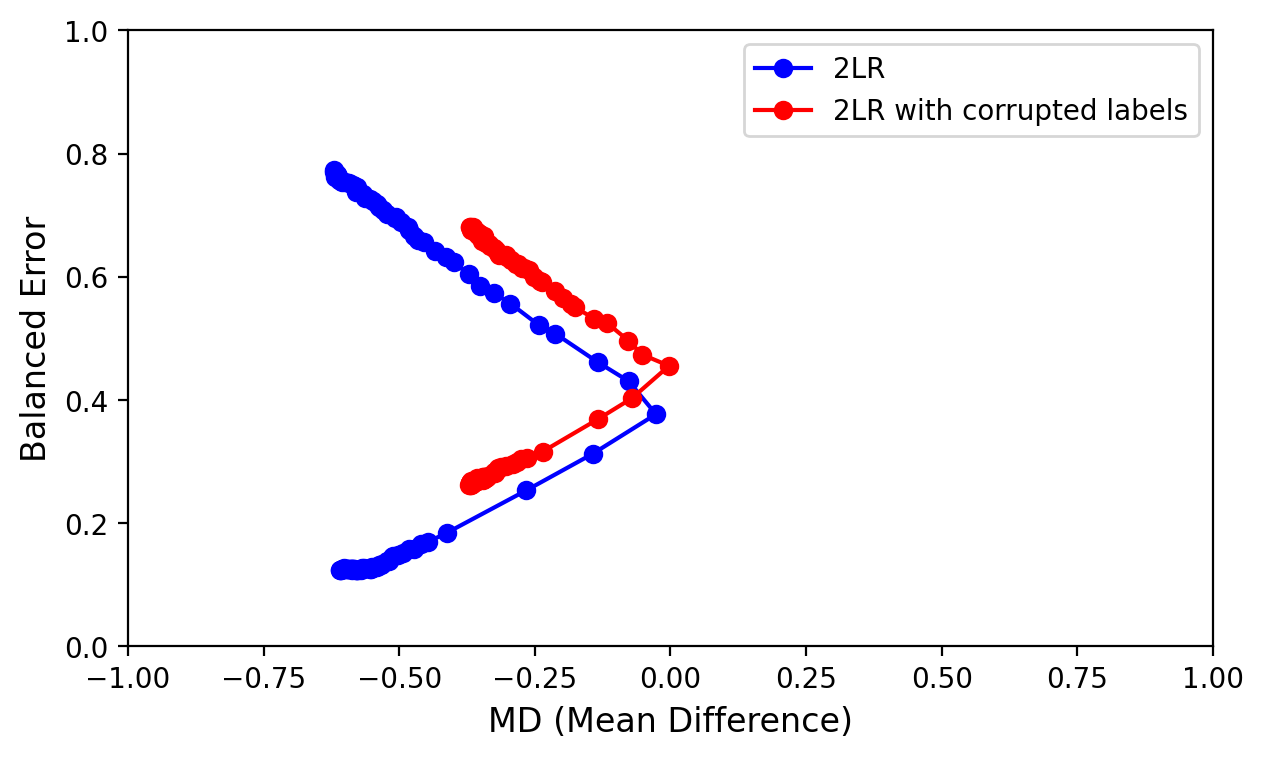

In [20]:
# Plot BER (y-axis) against MD (x-axis)
plt.figure(figsize=(7, 4))
# Plot BER vs MD
plt.plot(MD_list, BER_list, label="2LR", color="blue", marker='o')
plt.plot(MD_list_corr, BER_list_corr, label="2LR with corrupted labels", color="red", marker='o')

# Labels and Title
plt.xlabel("MD (Mean Difference)", fontsize=12)
plt.ylabel("Balanced Error", fontsize=12)

plt.xlim(-1, 1)
plt.ylim(0, 1)

plt.legend()
plt.savefig(f"../img/E1 - Label Noise/Label Noise MD {flip_prob:.2f} Flip Prob.png")


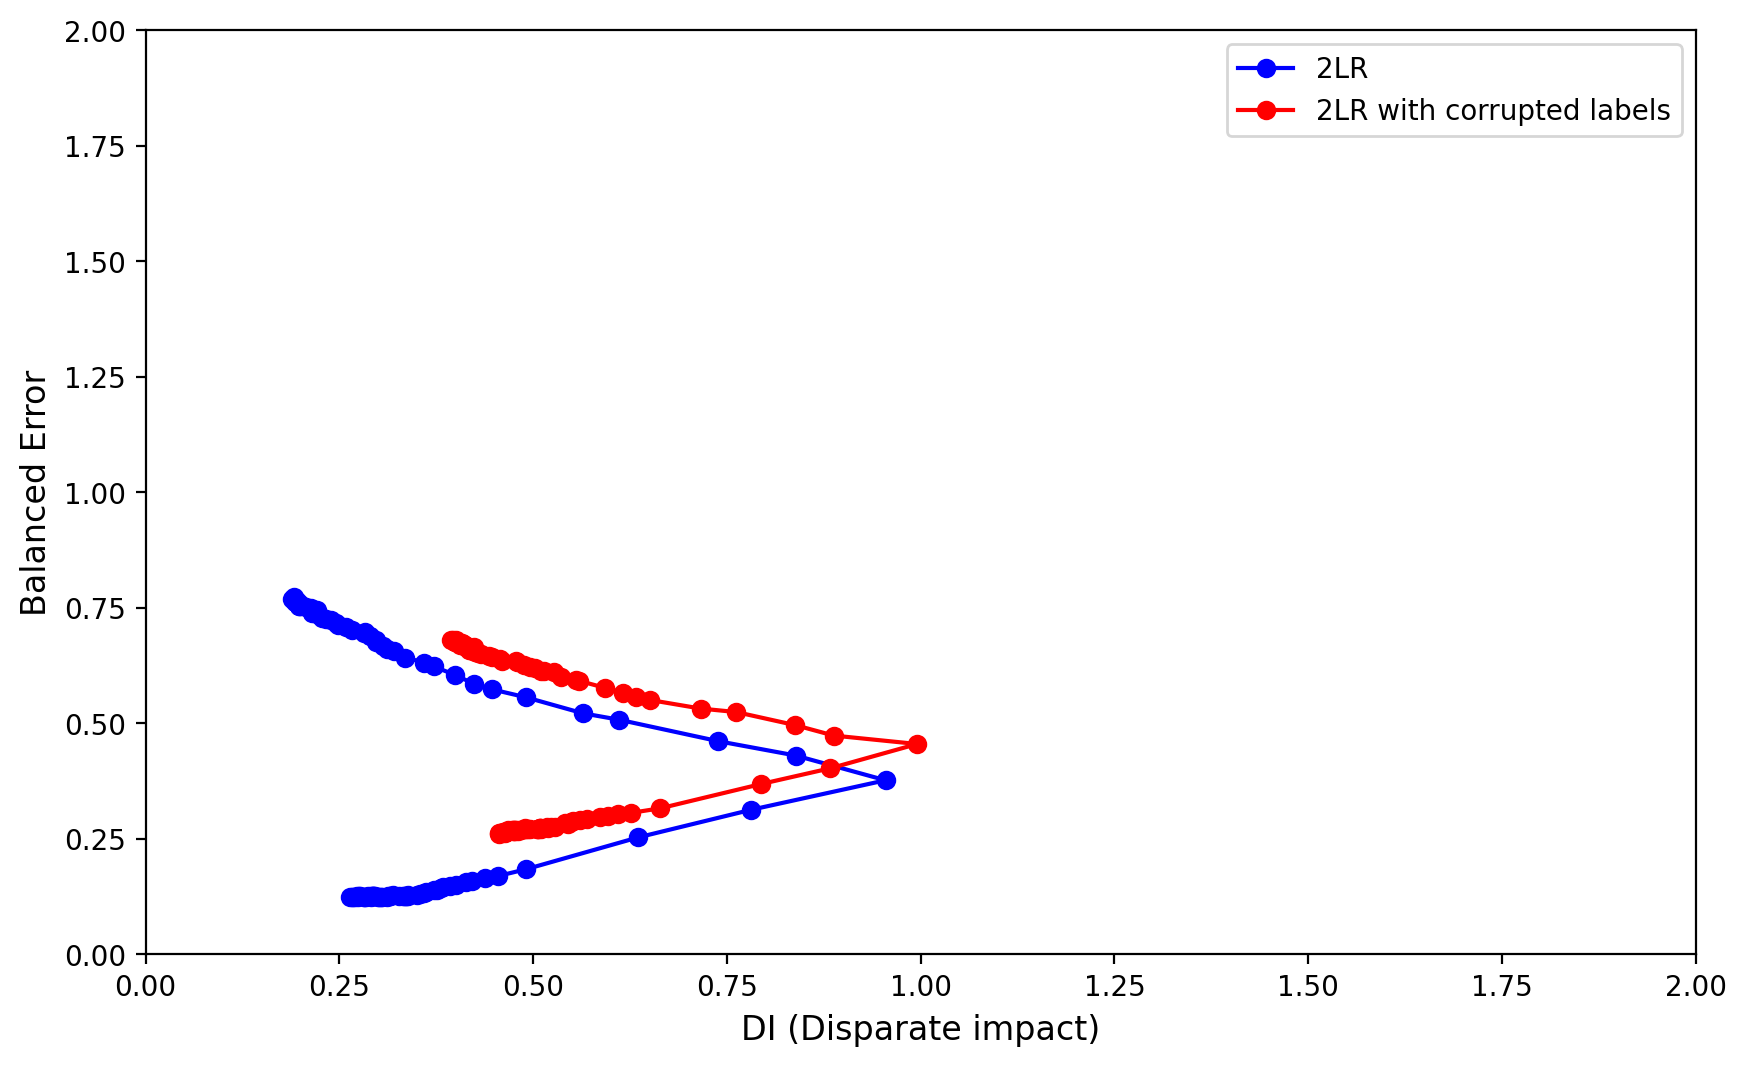

In [21]:
# Plot BER (y-axis) against MD (x-axis)
plt.figure(figsize=(10, 6))
# Plot BER vs MD
plt.plot(DI_list, BER_list, label="2LR", color="blue", marker='o')
plt.plot(DI_list_corr, BER_list_corr, label="2LR with corrupted labels", color="red", marker='o')

# Labels and Title
plt.xlabel("DI (Disparate impact)", fontsize=12)
plt.ylabel("Balanced Error", fontsize=12)

plt.xlim(0, 2)
plt.ylim(0, 2)

plt.legend()
plt.savefig(f"../img/E1 - Label Noise/Label Noise DI {flip_prob:.2f} Flip Prob.png")

### Try to understand dent

In [35]:

BER_list = []
MD_list = []

# Constants c and c_bar (cost sensitivity of classes)
c, c_bar = 0.5, 0.5
lmd = 1

# Calculate 's' for each lambda
s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)

# Apply step function H_a(z) with a = 0
Y_pred = np.where(s > 0, 1, 0)

TP, TN, FP, FN, FPR, FNR = calc_confusion_matrix(Y_pred, Y_test)
BER = calc_BER(Y_pred, Y_test)
MD = calc_MD(Y_pred, Y_sen_test)
BER_list.append(BER)
MD_list.append(MD)

print(FPR, FNR)
print()
print(BER, MD)

0.337573385518591 0.17280163599182005

0.2551875107552055 -0.28871175712108776
